# COMP5318: Assignment 1 - Image Classification

Author: Jesse Serina Narvasa <br>
SID: 500525438 <br>
Unikey: jnar3156


In order to consider classification performance, the specifications of the machine used to run this notebook is provided as follows:

Dell XPS 13 9350<br>
Intel Core i7-6560U 2.20GHz<br>
8GB RAM<br>
Integrated graphics<br>
Windows 10 Pro 19041.572

In [95]:
# Library imports

import time
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

In [96]:
# Loading our training data

with h5py.File('./Input/images_training.h5','r') as H:
    data_train = np.copy(H['datatrain'])
with h5py.File('./Input/labels_training.h5','r') as H:
    label_train = np.copy(H['labeltrain'])
    
# Loading our testing data

with h5py.File('./Input/images_testing.h5','r') as H:
    data_test = np.copy(H['datatest'])
with h5py.File('./Input/labels_testing_2000.h5','r') as H:
    label_test = np.copy(H['labeltest'])

In [97]:
# Verifying our loaded training data
print(data_train.shape, label_train.shape)

# Verifying our loaded testing data
print(data_test.shape, label_test.shape)

(30000, 784) (30000,)
(5000, 784) (2000,)


In [98]:
# Class mappings
class_mappings = {
    0: 'T-shirt/Top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

### Utility Functions

In [99]:
def calc_top1_accuracy(predicted, actual):
    '''
    Calculates the top-1 accuracy metric, given the predicted classes against the actual classes
    INPUT: 1D array of predicted results,
        1D array of actual results
    OUTPUT: percentage in decimal format of accuracy    
    '''
    correct = 0
    for n in range(actual.shape[0]):
        if predicted[n] == actual[n]:
            correct += 1
        
    return correct/actual.shape[0]

In [100]:
def output_prediction(predictions):
    '''
    Generates the output file for the predictions
    INPUT: 1D array of predicted results
    OUTPUT: prediction file of .h5 format
    '''
    with h5py.File('./Output/predicted_labels.h5','w') as H:
        H.create_dataset('Output',data=predictions)

In [101]:
def train_validation_split(train_ratio, data_train, label_train):
    '''
    Splits the dataset for X and y into training and validation datasets based on the given ratio
    INPUT: train split ratio, training dataset, label dataset
    OUTPUT: training data and label numpy arrays, validation data and label numpy arrays
    '''
    # obtain the row number where we conduct the split
    row_split = int(train_ratio * data_train.shape[0])
    
    # shuffle our matrices
    shuffled_idx = np.arange(data_train.shape[0])
    np.random.shuffle(shuffled_idx)
    data_train = data_train[shuffled_idx]
    label_train = label_train[shuffled_idx]
        
    # create the train/test split
    split_data_train = data_train[:row_split, :]
    split_label_train = label_train[:row_split]
    split_data_validation = data_train[row_split:, :]
    split_label_validation = label_train[row_split:]
    
    return split_data_train, split_label_train, split_data_validation, split_label_validation

### Pre-processing

#### PCA

In [102]:
def apply_pca(data_train, data_test, n_components=45):
    '''
    Apply PCA on the given dataset
    INPUT: 2D or 3D array dataset for data_train and data_test,
        INT n_components for the number of components to be retained, or set to STR 'dynamic' to count eigenvalues > 1
    OUTPUT: 2D array of dataset reduced to n dimensions
    '''
    if len(data_train.shape) != 2:
        data_train = data_train.reshape((data_train.shape[0], data_train.shape[1]**2))
    if len(data_test.shape) != 2:
        data_test = data_test.reshape((data_test.shape[0], data_test.shape[1]**2))
    
    # Need to get the mean of each feature, for mean normalisation/centreing
    data_train_mean = data_train.mean(axis=0)
    data_test_mean = data_test.mean(axis=0)
    # Feature means should now be zero, or approx. close to zero - and hence centred
    data_train_centred = np.subtract(data_train, data_train_mean)
    data_test_centred = np.subtract(data_test, data_test_mean)
    
    # Checking the following, we can see that the max and min value of the entire matrix is 0 and 1
    # hence scaling is not required
    '''
    print(data_train.min())
    print(data_train.max())
    print(data_test.min())
    print(data_test.max())
    '''
    
    covariance_matrix = (data_train_centred.T).dot(data_train_centred)
    l, V = np.linalg.eig(covariance_matrix)
    
    sorted_lambda_index =  l.argsort()[::-1] # sorting our lambda values from largest to smallest
    
    if n_components == 'dynamic':
        # The number of components to be retained for PCA, will be based on the number of eigenvalues which are > 1
        n_components = np.count_nonzero(l > 1)
        print(f'Number of factors retained is: {n_components}')
        
    V_n = V[:,sorted_lambda_index[:n_components]]
    
    # Do the projection of the image matrix against our orthogonal eigenvector matrix reduced to n columns
    pca_data_train = data_train_centred.dot(V_n)
    pca_data_test = data_test_centred.dot(V_n)
    
    return (pca_data_train, pca_data_test)

#### SVD

In [103]:
def apply_svd(data_train, data_test, n_components=45):
    '''
    Apply Singular Value Decomposition for a given training dataset,
    and subsequently apply our test dataset onto the same orthognal V
    '''
    if len(data_train.shape) != 2:
        data_train = data_train.reshape((data_train.shape[0], data_train.shape[1]**2))
    if len(data_test.shape) != 2:
        data_test = data_test.reshape((data_test.shape[0], data_test.shape[1]**2))
        
    U, s, Vt = np.linalg.svd(data_train, full_matrices=False)
        
    if n_components == 'dynamic':
        # to dynamically set what our n_components value will be
        # based on the number of singular values required to reach an energy level, where 1D array s is squared,
        # such that we get at least 90% of the total sum squared of s        
        s_squared = np.square(s)
        s_squared_sum = s_squared.sum()
        running_squared_sum = 0
        n_components = 0
        for idx, sing_val_sqrd in enumerate(s_squared):
            running_squared_sum += sing_val_sqrd
            if (running_squared_sum/s_squared_sum) > 0.9:
                n_components = idx + 1
                break
        print(f'Number of components retained is: {n_components}')
        
    # Since our singular values in array s are already sorted from largest to smallest, we can then remove
    # the insignificant singular values, and also remove the affected rows & columns from U and Vt
    # However, since we'll only use Vt, then we only apply it there
    if isinstance(n_components, int):
        Vt = Vt[:n_components, :]
    
    # We do dot product between our data matrix and Vt.T because Vt is already reduced to the orthonormal vectors
    # which have the highest singular value scores.  Moreover, we need to transpose Vt in order to do dot product
    # with our data matrix (data_train and/or data_test)
    svd_data_train = data_train.dot(Vt.T)
    svd_data_test = data_test.dot(Vt.T)
    
    return (svd_data_train, svd_data_test)

### Classification Algorithms

#### k-Nearest Neighbours

In [104]:
def knn(data_train, label_train, data_test, K=3):
    '''
    k-Nearest Neighbour classifier
    INPUT: 2D/3D array of training dataset (data_train),
        1D array of label of training dataset (label_train),
        2D/3D array of the dataset to be predicted (data_test),
        (optional) K number of nearest neighbours
    OUTPUT: 1D array of predicted results with the same length as data_test.shape[0]
    '''
    
    # Reshaping our input data, to ensure it's 2D
    if len(data_train.shape) != 2:
        data_train = data_train.reshape((data_train.shape[0], data_train.shape[1]**2))
    if len(data_test.shape) != 2:
        data_test = data_test.reshape((data_test.shape[0], data_test.shape[1]**2))
        
    # Instantiating our empty array for predicted values
    pred_test = np.zeros(data_test.shape[0])
    
    for image_num in range(data_test.shape[0]):
        # Calculating the distance difference between the test subject and all our training points
        sum_sqrd_distances = np.sqrt((np.square(np.subtract(data_train, data_test[image_num]))).sum(axis=1))
        #sum_sqrd_distances = np.linalg.norm(data_train - data_test[image_num], axis=1)
    
        # Getting the k nearest neighbours
        k_nearest_neighbours = (np.argsort(sum_sqrd_distances))[:K]
    
        classes_dict = {}

        # Using weighted distance, instead of simply using count
        for neighbour_idx in k_nearest_neighbours:
            classification = label_train[neighbour_idx]
            if classification in classes_dict:
                classes_dict[classification] += 1/(sum_sqrd_distances[neighbour_idx]**2)
            else:
                classes_dict[classification] = 1/(sum_sqrd_distances[neighbour_idx]**2)
            
        pred_class = None
        for key in classes_dict:
            if pred_class == None:
                pred_class = key
                continue

            if classes_dict[key] > classes_dict[pred_class]:
                pred_class = key
                
        pred_test[image_num] = pred_class
            
    return pred_test

#### Gaussian Naive Bayes

In [105]:
def gaussian_naive_bayes(data_train, label_train, data_test):
    '''
    Gaussian Naive Bayes classifier
    INPUT: 2D/3D array of training dataset (data_train),
        1D array of label on training dataset (label_train),
        2D/3D array of test dataset (data_test)
    OUTPUT: 1D array of predicted classes on test dataset
    '''
    
    # Reshaping if it's not the expected shape (2D)
    if len(data_train.shape) != 2:
        data_train = data_train.reshape((data_train.shape[0], data_train.shape[1]**2))
    if len(data_test.shape) != 2:
        data_test = data_test.reshape((data_test.shape[0], data_test.shape[1]**2))

    # Obtaining the different classes that we have present in our training data and getting index positions of each one
    class_indices = {}
    for idx, image_class in enumerate(label_train):
        if image_class not in class_indices:
            class_indices[image_class] = [idx]
            continue
        else:
            class_indices[image_class].append(idx)
        
    class_mean = {}
    class_var = {}

    # Obtain the mean and std dev for each class of our training data
    for class_index in class_indices:
        class_mean[class_index] = data_train[class_indices[class_index], :].mean(axis=0)
        class_var[class_index] = data_train[class_indices[class_index], :].var(axis=0)

    pred_test = np.zeros(data_test.shape[0])

    for image_num in range(data_test.shape[0]):
        # In order to find the length of pred_class_scores, we need to get the max value of the keys
        # with the assumption that each number up to the max will be a class
        # we do this instead of length because our training data may not have an entry for a class, hence, it'll
        # result in out of range if a data exists for one higher
        pred_class_scores = np.zeros(max(class_indices, key=int)+1)
        
        for class_index in class_indices:
            
            # Calculating the logged prior probability
            class_prob = np.log(len(class_indices[class_index])/data_train.shape[0])

            # Calculating the sum of the logged conditional probability
            likelihood_array = st.norm.logpdf(x=data_test[image_num], loc=class_mean[class_index], scale=np.sqrt(class_var[class_index]))
            class_prob = class_prob + np.nansum(likelihood_array) # we use nansum to avoid nan likelihoods, because these are obtained from points with zero variance

            # Storing the result in our results array, so we can keep track of which class has the highest
            pred_class_scores[class_index] = class_prob

        # Class with the highest prob is the predicted class for the image, which is stored in our final pred_test array
        pred_test[image_num] = np.nanargmax(pred_class_scores)
        
    return pred_test

#### Multinomial Logistic Regression

In [106]:
def calc_logistic_loss(weights, X, y, LAMBDA):
    '''
    Provides the gradient and the current loss, used during the logistic gradient descent process
    for finding the optimal weights
    INPUT: vector weights, training dataset (X), labels of training dataset (y), regularisation term (LAMBDA)
    OUTPUT: gradient (vector), current loss (scalar)
    '''
    
    # Basically the vector of inputs for our sigmoid function
    z = X.dot(weights)
    
    # Now placing it inside our sigmoid function.  This will produce vector of probabilities of size N
    prob = 1/(1 + np.exp(-z))
    
    # getting the gradient at the current point
    grad_loss = X.T.dot((prob - y))
    
    # getting the current loss, since we want to do minimisation problem (not maximisation)
    curr_loss = -((np.log(prob)).T.dot(y) + (np.log(1-prob)).T.dot(1-y)) + (LAMBDA/2 * (weights.T.dot(weights)))
    
    return grad_loss, curr_loss[0]


def multiclass_logistic_regression(data_train, label_train, data_test, LEARNING_RATE, LAMBDA, MAX_ITER):
    '''
    Function used for multinomial logistic regression - classification problem of multiple classes
    INPUT: training data, labels of training data, test/validation dataset, learning rate, regularisation term, iterations
    OUTPUT: predictions for the given test/validation dataset (vector)
    '''
    
    # first we do the pre-processing to make it easier for our gradient descent
    pca_data_train, pca_data_test = apply_pca(data_train, data_test, n_components=95)

    # getting the unique labels that we have in dataset
    labels = np.arange(np.max(label_train))

    optimal_weights = np.zeros((pca_data_train.shape[1], len(labels)))

    for label in labels:
        X0 = pca_data_train[np.where(label_train!=label)[0], :]
        X1 = pca_data_train[np.where(label_train==label)[0], :]
        y0 = np.zeros(X0.shape[0])
        y1 = np.ones(X1.shape[0])

        X = np.concatenate((X0, X1), axis=0)
        y = np.concatenate((y0, y1))[:, np.newaxis]

        N, D = X.shape
    
        # select a random starting point for our gradient descent
        weights = np.random.random(D)[:, np.newaxis]

        loss_array = []

        for _ in range(MAX_ITER):
            dloss, current_loss = calc_logistic_loss(weights, X, y, LAMBDA)
            weights = weights - (LEARNING_RATE * (dloss / N))

            loss_array.append(current_loss)

        plt.plot(list(range(MAX_ITER)), loss_array)
        plt.show()

        optimal_weights[:, label] = np.squeeze(weights)
        
    instance_prob_per_class = pca_data_test.dot(optimal_weights)
    predictions = np.argmax(instance_prob_per_class, axis=1)
        
    return predictions

### Hyperparameter Optimisation

#### k-Nearest Neighbours

In [ ]:
# Choose the best model out of each classifier by comparing accuracy results of hold-out method
# Then run hyperparameter optimisation on the best model
# run the results with our newly found hyper parameter against the test data
# Output the file and get prediction

# Do this for the other 2 classifiers too

In [12]:
# k-Nearest Neighbours Classifier using raw data as input
start = time.time()
knn_results = knn(data_train, label_train, data_test, K=5)
end = time.time()
print(f"Time taken is {end-start} seconds")
accuracy = calc_top1_accuracy(knn_results, label_test)
print(f"Accuracy result for kNN (raw) is: {accuracy}")
print()

# k-Nearest Neighbours Classifier with PCA
start = time.time()
pca_data_train, pca_data_test = apply_pca(data_train, data_test, n_components=43)
knn_pca_results = knn(pca_data_train, label_train, pca_data_test, K=5)
end = time.time()
print(f"Time taken is {end-start} seconds")
accuracy = calc_top1_accuracy(knn_pca_results, label_test)
print(f"Accuracy result for kNN (PCA) is: {accuracy}")
print()

# k-Nearest Neighbours Classifier with SVD
start = time.time()
svd_data_train, svd_data_test = apply_svd(data_train, data_test, n_components=43)
knn_svd_results = knn(svd_data_train, label_train, svd_data_test, K=5)
end = time.time()
print(f"Time taken is {end-start} seconds")
accuracy = calc_top1_accuracy(knn_svd_results, label_test)
print(f"Accuracy result for kNN (SVD) is: {accuracy}")

Time taken is 655.7662410736084 seconds
Accuracy result for kNN (raw) is: 0.8275

Time taken is 48.18245530128479 seconds
Accuracy result for kNN (PCA) is: 0.84

Time taken is 55.23245167732239 seconds
Accuracy result for kNN (SVD) is: 0.8395


In [16]:
# Hyperparameterisation

# Finding the best value of K (PCA)

N_RUNS = 3

for K in range(3,36, 3):
    accuracy_results = []
    for _ in range(N_RUNS):
        # do the shuffle and train/validation split
        split_data_train, split_label_train, split_data_validation, split_label_validation = train_validation_split(0.7, data_train, label_train)
        
        pca_data_train, pca_data_test = apply_pca(split_data_train, split_data_validation, n_components=43)
        knn_pca_results = knn(pca_data_train, split_label_train, pca_data_test, K=K)
        accuracy = calc_top1_accuracy(knn_pca_results, split_label_validation)
        accuracy_results.append(accuracy)
    print(f'Average accuracy result for K Nearest Neighbours with K={K} is {(sum(accuracy_results))/N_RUNS}')

Average accuracy result for K Nearest Neighbours with K=3 is 0.8467407407407407
Average accuracy result for K Nearest Neighbours with K=6 is 0.8501851851851852
Average accuracy result for K Nearest Neighbours with K=9 is 0.8509259259259259
Average accuracy result for K Nearest Neighbours with K=12 is 0.8483703703703703
Average accuracy result for K Nearest Neighbours with K=15 is 0.8507037037037036
Average accuracy result for K Nearest Neighbours with K=18 is 0.8468518518518519
Average accuracy result for K Nearest Neighbours with K=21 is 0.8478888888888889
Average accuracy result for K Nearest Neighbours with K=24 is 0.8415925925925926
Average accuracy result for K Nearest Neighbours with K=27 is 0.8414814814814816
Average accuracy result for K Nearest Neighbours with K=30 is 0.8386296296296297
Average accuracy result for K Nearest Neighbours with K=33 is 0.8424444444444444


In [21]:
# Hyperparameterisation

# Finding the best value of K (PCA)

N_RUNS = 1

for n_component in range(35,120, 5):
    accuracy_results = []
    for _ in range(N_RUNS):
        # do the shuffle and train/validation split
        split_data_train, split_label_train, split_data_validation, split_label_validation = train_validation_split(0.7, data_train, label_train)
        
        pca_data_train, pca_data_test = apply_pca(split_data_train, split_data_validation, n_components=n_component)
        knn_pca_results = knn(pca_data_train, split_label_train, pca_data_test, K=9)
        accuracy = calc_top1_accuracy(knn_pca_results, split_label_validation)
        accuracy_results.append(accuracy)
    print(f'Average accuracy result for K Nearest Neighbours with n_components={n_component} is {(sum(accuracy_results))/N_RUNS}')

Average accuracy result for K Nearest Neighbours with n_components=35 is 0.8504444444444444
Average accuracy result for K Nearest Neighbours with n_components=40 is 0.8473333333333334
Average accuracy result for K Nearest Neighbours with n_components=45 is 0.8597777777777778
Average accuracy result for K Nearest Neighbours with n_components=50 is 0.8534444444444444
Average accuracy result for K Nearest Neighbours with n_components=55 is 0.8518888888888889
Average accuracy result for K Nearest Neighbours with n_components=60 is 0.8548888888888889
Average accuracy result for K Nearest Neighbours with n_components=65 is 0.8473333333333334
Average accuracy result for K Nearest Neighbours with n_components=70 is 0.8511111111111112
Average accuracy result for K Nearest Neighbours with n_components=75 is 0.8541111111111112
Average accuracy result for K Nearest Neighbours with n_components=80 is 0.8576666666666667
Average accuracy result for K Nearest Neighbours with n_components=85 is 0.85777

In [17]:
# Hyperparameterisation

# Finding the best value of K (SVD)

N_RUNS = 3

for K in range(3,36, 3):
    accuracy_results = []
    for _ in range(N_RUNS):
        # do the shuffle and train/validation split
        split_data_train, split_label_train, split_data_validation, split_label_validation = train_validation_split(0.7, data_train, label_train)
        
        svd_data_train, svd_data_test = apply_svd(split_data_train, split_data_validation, n_components=43)
        knn_svd_results = knn(svd_data_train, split_label_train, svd_data_test, K=K)
        accuracy = calc_top1_accuracy(knn_svd_results, split_label_validation)
        accuracy_results.append(accuracy)
    print(f'Average accuracy result for K Nearest Neighbours with K={K} is {(sum(accuracy_results))/N_RUNS}')

Average accuracy result for K Nearest Neighbours with K=3 is 0.8448888888888889
Average accuracy result for K Nearest Neighbours with K=6 is 0.8495555555555555
Average accuracy result for K Nearest Neighbours with K=9 is 0.8505185185185186
Average accuracy result for K Nearest Neighbours with K=12 is 0.8490000000000001
Average accuracy result for K Nearest Neighbours with K=15 is 0.8478148148148148
Average accuracy result for K Nearest Neighbours with K=18 is 0.8447037037037036
Average accuracy result for K Nearest Neighbours with K=21 is 0.8432962962962963
Average accuracy result for K Nearest Neighbours with K=24 is 0.8406296296296296
Average accuracy result for K Nearest Neighbours with K=27 is 0.8453703703703703
Average accuracy result for K Nearest Neighbours with K=30 is 0.8434074074074074
Average accuracy result for K Nearest Neighbours with K=33 is 0.8407037037037037


In [22]:
# Hyperparameterisation

# Finding the best value of n_component (SVD)

N_RUNS = 1

for n_component in range(70,120, 5):
    accuracy_results = []
    for _ in range(N_RUNS):
        # do the shuffle and train/validation split
        split_data_train, split_label_train, split_data_validation, split_label_validation = train_validation_split(0.7, data_train, label_train)
        
        svd_data_train, svd_data_test = apply_svd(split_data_train, split_data_validation, n_components=n_component)
        knn_svd_results = knn(svd_data_train, split_label_train, svd_data_test, K=10)
        accuracy = calc_top1_accuracy(knn_svd_results, split_label_validation)
        accuracy_results.append(accuracy)
    print(f'Average accuracy result for n_components retained for SVD with n_component={n_component} is {(sum(accuracy_results))/N_RUNS}')

Average accuracy result for n_components retained for SVD with n_component=70 is 0.8511111111111112
Average accuracy result for n_components retained for SVD with n_component=75 is 0.8492222222222222
Average accuracy result for n_components retained for SVD with n_component=80 is 0.8512222222222222
Average accuracy result for n_components retained for SVD with n_component=85 is 0.856
Average accuracy result for n_components retained for SVD with n_component=90 is 0.8476666666666667
Average accuracy result for n_components retained for SVD with n_component=95 is 0.8532222222222222
Average accuracy result for n_components retained for SVD with n_component=100 is 0.8566666666666667
Average accuracy result for n_components retained for SVD with n_component=105 is 0.8495555555555555
Average accuracy result for n_components retained for SVD with n_component=110 is 0.8494444444444444
Average accuracy result for n_components retained for SVD with n_component=115 is 0.8537777777777777


In [20]:
# Hyperparameterisation

# Finding the best value of K (SVD)

N_RUNS = 3

for K in range(5,10, 1):
    accuracy_results = []
    for _ in range(N_RUNS):
        # do the shuffle and train/validation split
        split_data_train, split_label_train, split_data_validation, split_label_validation = train_validation_split(0.7, data_train, label_train)
        
        svd_data_train, svd_data_test = apply_svd(split_data_train, split_data_validation, n_components=75)
        knn_svd_results = knn(svd_data_train, split_label_train, svd_data_test, K=K)
        accuracy = calc_top1_accuracy(knn_svd_results, split_label_validation)
        accuracy_results.append(accuracy)
    print(f'Average accuracy result for K Nearest Neighbours with K={K} is {(sum(accuracy_results))/N_RUNS}')

Average accuracy result for K Nearest Neighbours with K=5 is 0.8497407407407408
Average accuracy result for K Nearest Neighbours with K=6 is 0.8495555555555555
Average accuracy result for K Nearest Neighbours with K=7 is 0.8508888888888889
Average accuracy result for K Nearest Neighbours with K=8 is 0.852925925925926
Average accuracy result for K Nearest Neighbours with K=9 is 0.8537037037037036


#### Gaussian Naive Bayes

In [ ]:
# Hyperparameterisation

# Finding the best n_components value for PCA

N_RUNS = 3

for n_component in range(70,100, 5):
    accuracy_results = []
    for _ in range(N_RUNS):
        # do the shuffle and train/validation split
        split_data_train, split_label_train, split_data_validation, split_label_validation = train_validation_split(0.7, data_train, label_train)
        
        pca_data_train, pca_data_test = apply_pca(split_data_train, split_data_validation, n_components=n_component)
        nb_pca_results = gaussian_naive_bayes(pca_data_train, split_label_train, pca_data_test)
        accuracy = calc_top1_accuracy(nb_pca_results, split_label_validation)
        accuracy_results.append(accuracy)
    print(f'Average accuracy result for PCA components retained={n_component} is {(sum(accuracy_results))/N_RUNS}')

In [ ]:
'''
# Gaussian Naive Bayes using raw data as input
start = time.time()
nb_results = gaussian_naive_bayes(data_train, label_train, data_test)
end = time.time()
print(f"Time taken is {end-start} seconds")
accuracy = calc_top1_accuracy(nb_results, label_test)
print(f"Accuracy result for NB (raw) is: {accuracy}")
print()
'''

# Gaussian Naive Bayes applied on principal components of dataset
start = time.time()
pca_data_train, pca_data_test = apply_pca(data_train, data_test, n_components=95)
nb_pca_results = gaussian_naive_bayes(pca_data_train, label_train, pca_data_test)
end = time.time()
print(f"Time taken is {end-start} seconds")
accuracy = calc_top1_accuracy(nb_pca_results, label_test)        
print(f"Accuracy result for NB (PCA) is: {accuracy}")
print()
'''
# Gaussian Naive Bayes applied on SVD of dataset
start = time.time()
svd_data_train, svd_data_test = apply_svd(data_train, data_test, n_components=50)
nb_svd_results = gaussian_naive_bayes(svd_data_train, label_train, svd_data_test)
end = time.time()
print(f"Time taken is {end-start} seconds")
accuracy = calc_top1_accuracy(nb_svd_results, label_test)
print(f"Accuracy result for NB (SVD) is: {accuracy}")
'''

#### Multinomial Logistic Regression

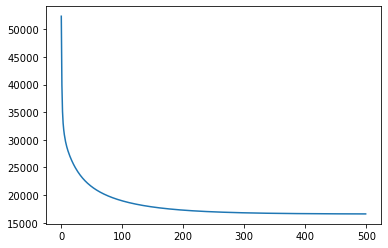

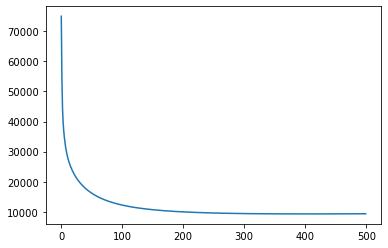

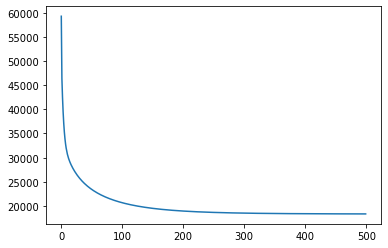

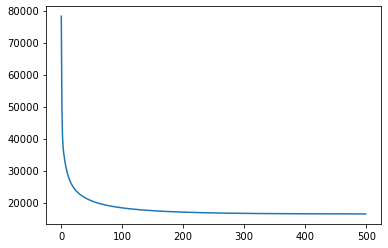

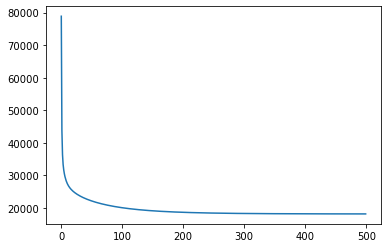

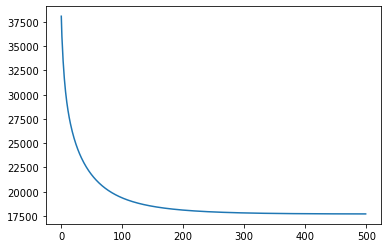

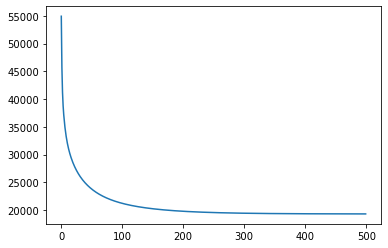

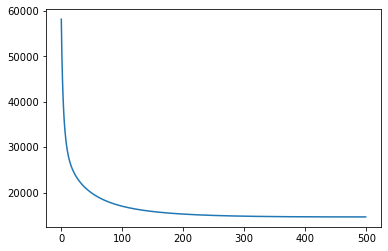

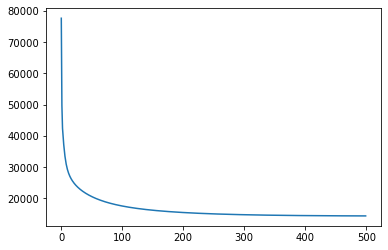

0.6975


In [94]:
LEARNING_RATE = 0.4
LAMBDA = 100
MAX_ITER = 500

predictions = multiclass_logistic_regression(data_train, label_train, data_test, LEARNING_RATE, LAMBDA, MAX_ITER)
accuracy = calc_top1_accuracy(predictions, label_test)
print(accuracy)

### Output of Best Classifier

In [ ]:
output_prediction(nb_svd_results)